# *Cohort Analysis With Python*

In [1]:
# Data structured
import numpy as np
import pandas as pd
import datetime as dt

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
df = pd.read_csv('OnlineRetail.csv', encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### ***Explore and Cleaning Data***

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Data type of *InvoiceDate* is object, it will be changed to *datetime*.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


*Quantity* and *UnitPrice* have negative value. It must haven't, so for the next step it will be filtered.

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<AxesSubplot:>

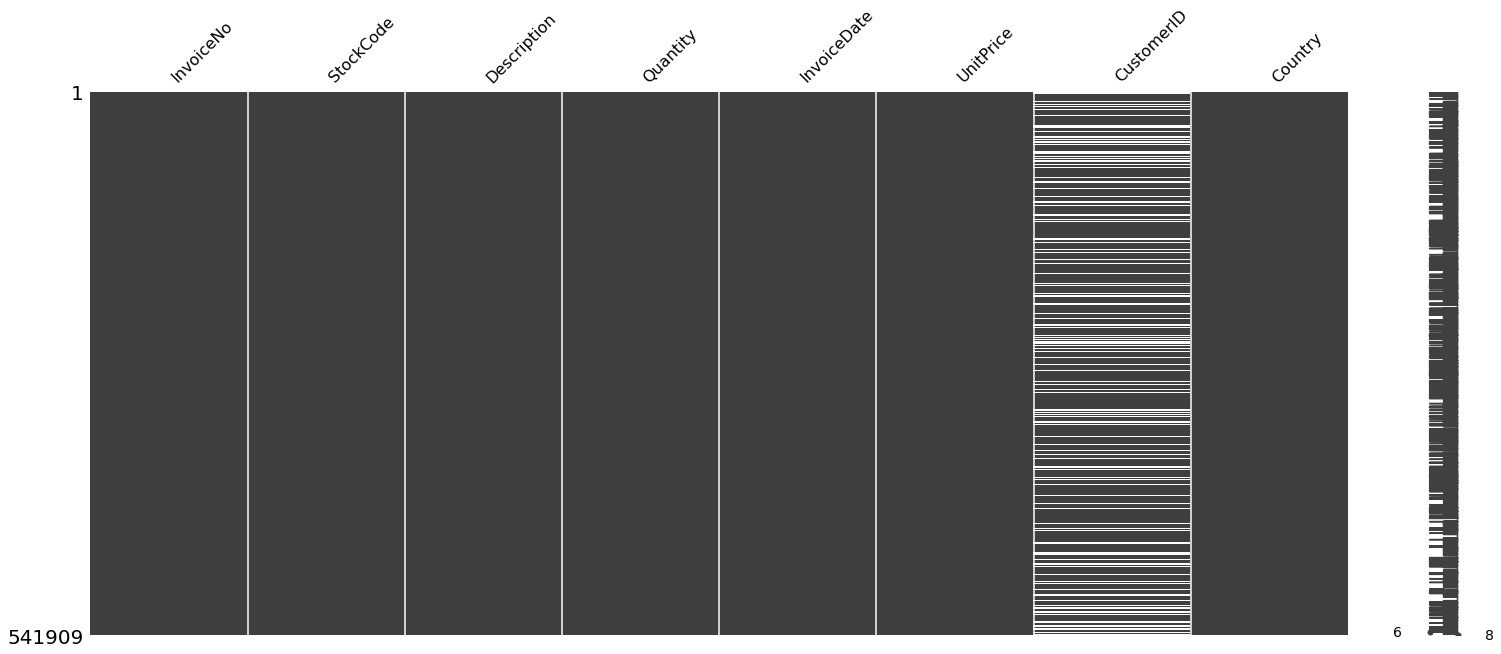

In [5]:
display(df.isnull().sum())
msno.matrix(df)

We want to do cohort analysis that analysis the retention rate of every customer. So we will remove the *CustomerID* data with null value.

Filter data with following criteria.
1. Change InvoiceDate Data Type
2. Filter negative value of *Quantity* and *UnitPrice*
3. Filter *CustomerID* that have null value

In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df = df[(df['CustomerID'].notnull())]

display(df.info())
display(df.describe().T)
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


None

,count,mean,std,min,25%,50%,75%,max
Quantity,397884.0,12.988238,179.331775,1.000,2.00,6.00,12.00,80995.00
UnitPrice,397884.0,3.116488,22.097877,0.001,1.25,1.95,3.75,8142.75
CustomerID,397884.0,15294.423453,1713.141560,12346.000,13969.00,15159.00,16795.00,18287.00


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Data is already clean and ready to use for Cohort Analysis.

### ***Cohort Analysis***

First step of do cohort analysis, we have to group the customer by the first month they purchase and next month they purchase by the time first purchasing.

In [41]:
def get_month(x): 
    return dt.datetime(x.year, x.month, 1)

def get_groupping_data(df):
    # Join
    df_new = pd.merge(df[['CustomerID', 'Country', 'InvoiceNo', 'InvoiceDate']],
                      df.groupby('CustomerID', as_index=False)['InvoiceDate'].min().rename(columns = {'InvoiceDate': 'FirstInvoiceDate'}), 
                      how='left')
    df_new['FirstInvoiceDate'] = df_new['FirstInvoiceDate'].apply(get_month)
    
    year_diff = (df_new['InvoiceDate'].dt.year - df_new['FirstInvoiceDate'].dt.year)
    month_diff = (df_new['InvoiceDate'].dt.month - df_new['FirstInvoiceDate'].dt.month)
    
    df_new['MonthIndex'] = year_diff*12 + month_diff + 1

    # Groupping
    groups = df_new.groupby(['FirstInvoiceDate', 'MonthIndex'])
    cohort_data = groups['CustomerID'].apply(pd.Series.nunique).reset_index()
    
    return cohort_data

groupping_data_by_first_month_uk = get_groupping_data(df[df['Country'] == 'United Kingdom'])
groupping_data_by_first_month_ger_fr = get_groupping_data(df[(df['Country'] == 'Germany') | (df['Country'] == 'France')])

groupping_data_by_first_month_uk

,FirstInvoiceDate,MonthIndex,CustomerID
0,2010-12-01,1,815
1,2010-12-01,2,289
2,2010-12-01,3,263
3,2010-12-01,4,304
4,2010-12-01,5,293
...,...,...,...
86,2011-10-01,2,79
87,2011-10-01,3,36
88,2011-11-01,1,297
89,2011-11-01,2,35


Next step we will create pivot table and retention rate from the groupping data before.

In [43]:
def get_pivot_data(group_data):
    return group_data.pivot(index='FirstInvoiceDate', columns='MonthIndex', values='CustomerID')

pivot_data_uk = get_pivot_data(groupping_data_by_first_month_uk)
pivot_data_ger_fr = get_pivot_data(groupping_data_by_first_month_ger_fr)

pivot_data_uk

MonthIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
FirstInvoiceDate,,,,,,,,,,,,,
2010-12-01,815.0,289.0,263.0,304.0,293.0,323.0,291.0,278.0,289.0,325.0,299.0,405.0,218.0
2011-01-01,358.0,76.0,93.0,84.0,119.0,99.0,90.0,87.0,108.0,117.0,127.0,43.0,NaN
2011-02-01,340.0,64.0,66.0,97.0,98.0,86.0,87.0,96.0,90.0,104.0,25.0,NaN,NaN
2011-03-01,419.0,64.0,109.0,83.0,94.0,69.0,111.0,96.0,119.0,38.0,NaN,NaN,NaN
2011-04-01,277.0,58.0,56.0,60.0,56.0,61.0,61.0,73.0,20.0,NaN,NaN,NaN,NaN
2011-05-01,256.0,48.0,44.0,44.0,53.0,58.0,68.0,23.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,214.0,38.0,31.0,51.0,51.0,69.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,169.0,30.0,33.0,39.0,47.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,141.0,32.0,32.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
def get_retention_rate(cohort_pivot_data):
    cohort_percent = cohort_pivot_data.loc[:,1]
    
    def divided(val): return (val/cohort_percent)
    
    retention_rate_data = cohort_pivot_data.apply(divided)
    return retention_rate_data

retention_rate_data_uk = get_retention_rate(pivot_data_uk)
retention_rate_data_ger_fr = get_retention_rate(pivot_data_ger_fr)

display(retention_rate_data_uk.round(2))

MonthIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
FirstInvoiceDate,,,,,,,,,,,,,
2010-12-01,1.0,0.35,0.32,0.37,0.36,0.40,0.36,0.34,0.35,0.40,0.37,0.50,0.27
2011-01-01,1.0,0.21,0.26,0.23,0.33,0.28,0.25,0.24,0.30,0.33,0.35,0.12,NaN
2011-02-01,1.0,0.19,0.19,0.29,0.29,0.25,0.26,0.28,0.26,0.31,0.07,NaN,NaN
2011-03-01,1.0,0.15,0.26,0.20,0.22,0.16,0.26,0.23,0.28,0.09,NaN,NaN,NaN
2011-04-01,1.0,0.21,0.20,0.22,0.20,0.22,0.22,0.26,0.07,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.19,0.17,0.17,0.21,0.23,0.27,0.09,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.18,0.14,0.24,0.24,0.32,0.10,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.18,0.20,0.23,0.28,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.23,0.23,0.24,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After the retention rate from pivot data is created, we just only make it to heatmaps, boxplot, and lineplot to compare and analysis the data as you can see in following code.

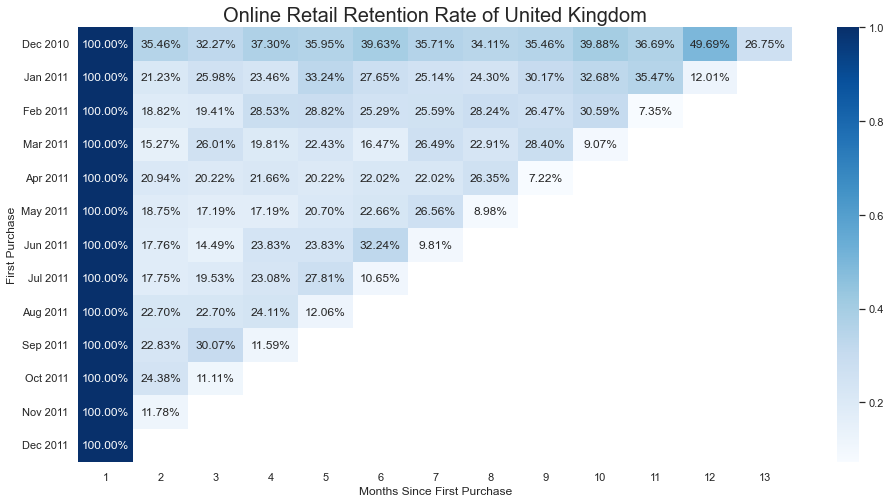

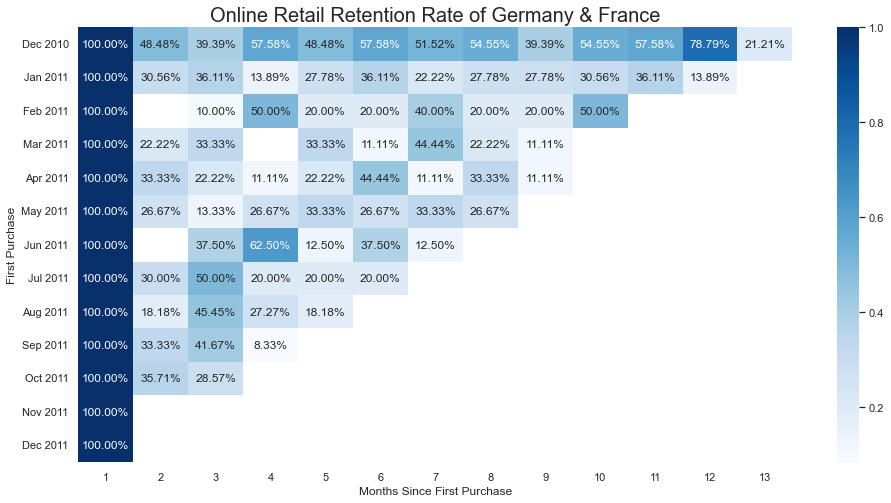

In [38]:
# Show Heatmap of retention rate
plt.figure(figsize=(16, 8))
yticklabels = pd.date_range('2010-12-01', '2011-12-01', freq='1MS').strftime('%b %Y')
ax=sns.heatmap(data=retention_rate_data_uk, annot=True, cmap='Blues', fmt='.2%', yticklabels=yticklabels)
plt.title('Online Retail Retention Rate of United Kingdom', size=20)
plt.ylabel('First Purchase')
plt.xlabel('Months Since First Purchase')
plt.show()

plt.figure(figsize=(16, 8))
yticklabels = pd.date_range('2010-12-01', '2011-12-01', freq='1MS').strftime('%b %Y')
sns.heatmap(data=retention_rate_data_ger_fr, annot=True, cmap='Blues', fmt='.2%', yticklabels=yticklabels)
plt.title('Online Retail Retention Rate of Germany & France', size=20)
plt.ylabel('First Purchase')
plt.xlabel('Months Since First Purchase')
plt.show()

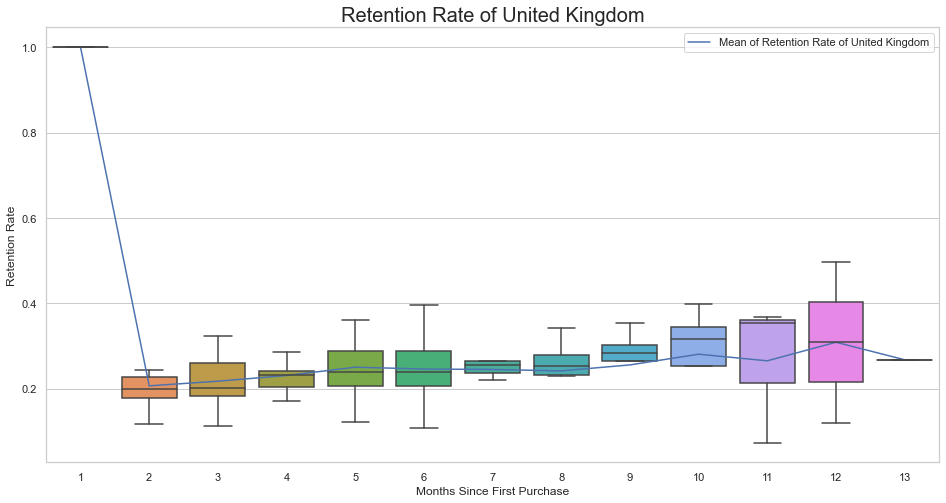

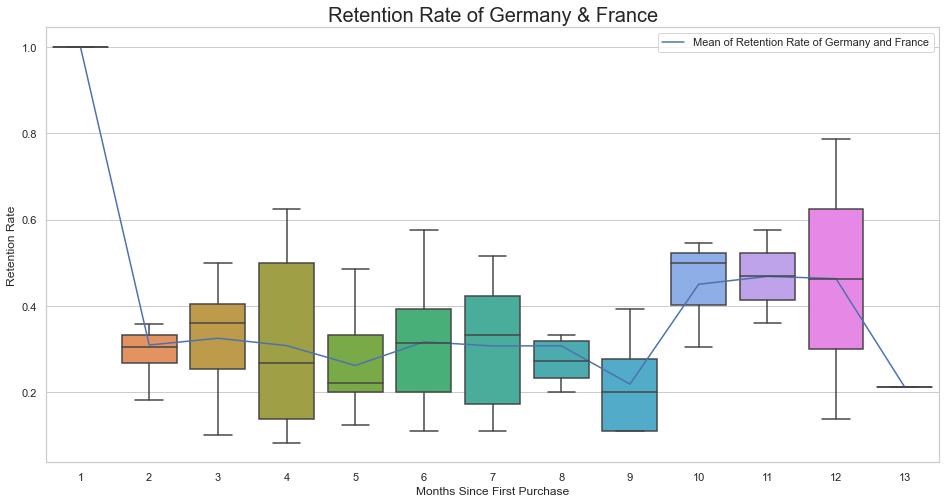

In [11]:
# Show line and boxplot of retention rate
mean_uk = [retention_rate_data_uk.iloc[:, i].mean() for i in range(retention_rate_data_uk.shape[0])]
mean_ger_fr = [retention_rate_data_ger_fr.iloc[:, i].mean() for i in range(retention_rate_data_ger_fr.shape[0])]
sns.set_theme()
sns.set_style('whitegrid')

plt.figure(figsize=(16, 8))
sns.boxplot(data=retention_rate_data_uk, showfliers=False)
sns.lineplot(y=mean_uk, x=range(retention_rate_data_uk.shape[0]), label='Mean of Retention Rate of United Kingdom')
plt.title('Retention Rate of United Kingdom', size=20)
plt.xlabel('Months Since First Purchase')
plt.ylabel('Retention Rate')
plt.show()

plt.figure(figsize=(16, 8))
sns.boxplot(data=retention_rate_data_ger_fr, showfliers=False)
sns.lineplot(y=mean_ger_fr, x=range(retention_rate_data_ger_fr.shape[0]), label='Mean of Retention Rate of Germany and France')
plt.title('Retention Rate of Germany & France', size=20)
plt.ylabel('Retention Rate')
plt.xlabel('Months Since First Purchase')
plt.show()

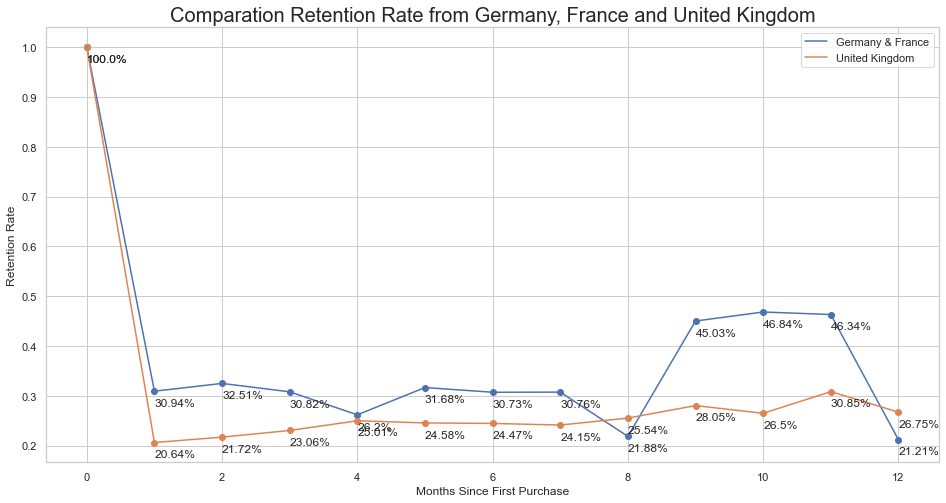

In [15]:
# Show line and boxplot of retention rate
x_position_ger_fr = [i for i in range(retention_rate_data_ger_fr.shape[0])]
x_position_uk = [i for i in range(retention_rate_data_uk.shape[0])]

plt.figure(figsize=(16, 8))

sns.lineplot(y=mean_ger_fr, x=range(retention_rate_data_ger_fr.shape[0]), label='Germany & France')
sns.lineplot(y=mean_uk, x=range(retention_rate_data_uk.shape[0]), label='United Kingdom')

plt.scatter(y=mean_ger_fr, x=range(retention_rate_data_ger_fr.shape[0]))
plt.scatter(y=mean_uk, x=range(retention_rate_data_uk.shape[0]))

for i, txt in enumerate(mean_ger_fr):
    plt.annotate(f'{round(txt*100, 2)}%', (x_position_ger_fr[i], (mean_ger_fr[i]-0.03)))
for i, txt in enumerate(mean_uk):
    plt.annotate(f'{round(txt*100, 2)}%', (x_position_uk[i], (mean_uk[i]-0.03)))
    
plt.title('Comparation Retention Rate from Germany, France and United Kingdom', size=20)
plt.ylabel('Retention Rate')
plt.xlabel('Months Since First Purchase')
plt.show()

***Conclusion***
1. In second month and the next, retention rate UK lower than Germany and France. However, it more stable than Germany & France have more tends fluctuating.
2. In United Kingdom, the lowest retention rate from the first month to second month is *88.22%* which occured in November 2011 group. The user acquisition strategic in this month need to be avoided caused the worst performance in user engagement.
3. Retention rate of United Kingdom with the group which have first purchase in December 2010 *ALWAYS* higher than the other group. It indicates the strategic in the time of user acquisition is better.